In [1]:
!python3 --version

Python 3.8.10


**Julien VALENTIN**, **Mars 2022**

In [2]:
from matplotlib import animation
from matplotlib import pyplot
import numpy

# Transport d'un signal lisse

On souhaite simuler le transport de la fonction lisse 
$$
    u : \left\{
        \begin{array}{rcl}
            [0,1] \times [0,2\pi] & \longrightarrow & \mathbb{R} \\
            (t, x)             & \longmapsto & \sin(x-t)
        \end{array} \right.
$$

$u$ est analytique sur son domaine et vérifie

\begin{align}
\partial_t u(t,x) + \partial_x u(t,x) & = 0 & \forall (t, x) \in (0, 1) \times (0, 2\pi) \\
u(t, 0) & = u(t, 2\pi) & \forall t \in (0, 1) \\
u(0, x) & = \sin(x) & \forall x \in (0, 2\pi) 
\end{align}

In [3]:
# Setup
cfl = 1                               # paramètre numérique
u0  = lambda x : numpy.sin(x)         # condition initiale
u   = lambda t, x : numpy.sin(x-t)    # solution analytique

# Discrétisation spatiale
xg = 0.                            # limite inférieure de l'intervalle
xd = 2 * numpy.pi                  # limite supérieure de l'intervalle
dx = .025                          # pas d'espace
nx = int( (xd-xg)/dx ) + 1         # nombre de noeuds en espace
Ox = numpy.linspace(xg, xd, nx)    # vecteur des absisses

# Discrétisation temporelle
t0 = 0.                       # date initiale
tf = 1.                       # date finale
dt = cfl * dx                 # pas de temps
nt = int( (tf-t0)/dt ) + 1    # nombre d'itérations en temps

# Schéma upwind

Le schéma se met sous la forme, dans le cas $a>0$

$$ u^{k+1}_i = u^k_i - \frac{\Delta t}{\Delta x} \left( u^{k-1}_i - u^{k-1}_{i-1} \right) $$

Il est $L^2$ et $L^\infty$ stable, sous condition $a \Delta t \leqslant \Delta x$ et son erreur de troncature est en $\mathcal{O}(\Delta t + \Delta x)$

In [4]:
Uh = numpy.zeros((nt, nx))
Uh[0, :] = u0(Ox)

for k in range(1, nt):    # itération temporelle
    
    for i in range(nx):    # itération spatiale
        
        Uh[k, i] = Uh[k-1, i] - dt/dx * ( Uh[k-1, i] - Uh[k-1, i-1] )    # upwind pas-à-pas

U = u(1, Ox)    # interpolation de la solution analytique

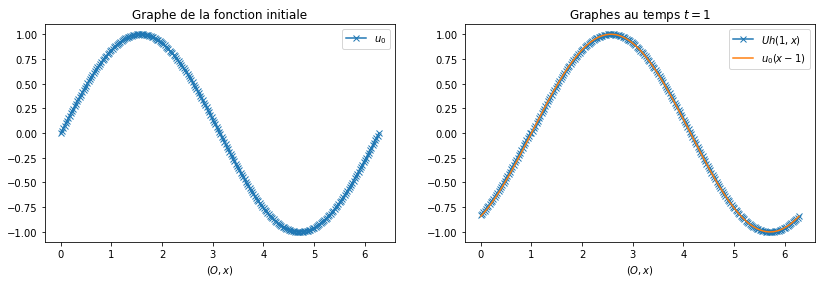

In [5]:
fig, ax, = pyplot.subplots(1, 2)
fig.set_figwidth(2.3 * fig.get_figwidth())

ax[0].plot(Ox, Uh[0,:], label="$u_0$", marker="x")
ax[0].legend()
ax[0].set_title("Graphe de la fonction initiale")
ax[0].set_xlabel("$(O,x)$")

ax[1].plot(Ox, Uh[-1,:], label="$Uh(1,x)$", marker="x")
ax[1].plot(Ox, U, label="$u_0(x-1)$")
ax[1].legend()
ax[1].set_title("Graphes au temps $t=1$")
ax[1].set_xlabel("$(O,x)$")

pyplot.show()

# Schéma explicite centré

Il s'écrit

$$ u^k_i = u^{k-1}_i - \frac{\Delta t}{2 \Delta x} \left( u^{k-1}_{i+1} - u^{k-1}_{i-1} \right) $$ Il est toujours instable et son erreur de troncature est en $\mathcal{O}(\Delta t + \Delta x^2)$

In [6]:
Uh = numpy.zeros((nt, nx))
Uh[0, :] = u0(Ox)

for k in range(1, nt):
    
    for i in range(nx-1):
        
        Uh[k, i] = Uh[k-1, i] - dt/(2*dx) * ( Uh[k-1, i+1] - Uh[k-1, i-1] )     # explicite centré pas-à-pas
    
    Uh[k, nx-1] = Uh[k-1, nx-1] - dt/(2*dx) * ( Uh[k-1, 0] - Uh[k-1, nx-2] )    # condition périodique, à droite

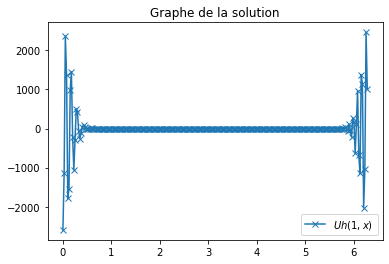

In [7]:
pyplot.plot(Ox, Uh[-1, :], label="$Uh(1,x)$", marker='x')
pyplot.legend()
pyplot.title("Graphe de la solution")
pyplot.show()

# Schéma implicite centré

# Schéma de Lax-Wendroff

Il s'écrit

$$ u^k_i = u^{k-1}_i - \frac{\Delta t}{2 \Delta x} \left( u^{k-1}_{i+1} - u^{k-1}_{i-1} \right) + \frac{\Delta t^2}{2 \Delta x^2} \left( u^{k-1}_{i+1} - 2 u^{k-1}_{i} + u^{k-1}_{i-1} \right)$$

Il est $L^2$-stable sous condition $a \Delta t \leqslant \Delta x$ et $L^\infty$-stable en cas d'égalité. Son erreur de troncature est en $\mathcal{O}(\Delta t^2 + \Delta x^2)$

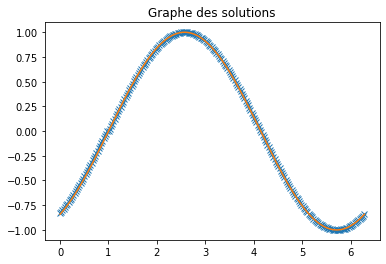

In [8]:
Uh = numpy.zeros((nt, nx))
Uh[0, :] = u0(Ox)

for k in range(1, nt):
    
    for i in range(nx-1):
        
        Uh[k, i] = Uh[k-1, i] - dt/(2*dx) * ( Uh[k-1, i+1] - Uh[k-1, i-1] )  + dt**2/(2*dx**2) * ( Uh[k-1, i+1] - 2*Uh[k-1, i] + Uh[k-1, i-1] )
    
    Uh[k, nx-1] = Uh[k-1, nx-1] - dt/(2*dx) * ( Uh[k-1, 0] - Uh[k-1, nx-2] )  + dt**2/(2*dx**2) * ( Uh[k-1, 0] - 2*Uh[k-1, nx-1] + Uh[k-1, nx-2] )

pyplot.plot(Ox, Uh[-1, :], marker='x')
pyplot.plot(Ox, U)
pyplot.title("Graphes à $t=1$")
pyplot.show()

# Schéma de Lax-Friedrichs

$$ u^k_i = \frac{1}{2} \left( u^{k-1}_{i+1} - u^{k-1}_{i-1} \right) - \frac{\Delta t}{2 \Delta x} \left( u^{k-1}_{i+1} - u^{k-1}_{i-1} \right) $$

Il est $L^2$ et $L^\infty$-stable sous condition $a \Delta t \leqslant \Delta x$. Son erreur de troncature est en $\mathcal{O}\left(\Delta t + \frac{\Delta x^2}{\Delta t}\right)$

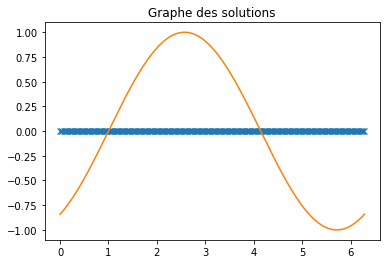

# Schéma de Beam-Warming

$$ u^k_i = u^{k-1}_i - \frac{\Delta t}{2 \Delta x} \left( 3 u^{k-1}_{i} - 4 u^{k-1}_{i-1} + u^{k-1}_{i-2} \right) + \frac{\Delta t^2}{\Delta x^2} \left( u^{k-1}_i - 2u^{k-1}_{i-1} + u^{k-1}_{i-2} \right) $$

$L^2$-stable sous condition $a \Delta t \leqslant 2 \Delta x$. $\mathcal{O}(\Delta t^2 + \Delta x^2)$

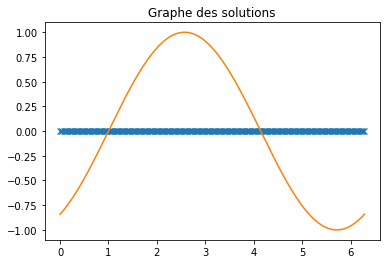